In [26]:
# ============================================================================
# FOOTBALL DATA ENGINEERING AVEC PYSPARK ⚽
# Pipeline d'analyse des performances footballistiques Bundesliga (2000-2015)
# Auteur: Omar Hitar
# Date: 05/10/2025
# ============================================================================

# ========================================
# 📦 INSTALLATION ET CONFIGURATION
# ========================================

print("🚀 Démarrage du pipeline PySpark Football Analytics...")
print("=" * 80)

# Installation de PySpark sur Google Colab
!pip install pyspark -q

# Imports nécessaires
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, sum as spark_sum, count, avg,
    round as spark_round, row_number, lit
)
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuration et création de la session Spark
spark = SparkSession.builder \
    .appName("Football Data Analysis - Bundesliga 2000-2015") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("\n✅ Spark Session créée avec succès!")
print(f"📊 Version Spark: {spark.version}")
print(f"📝 Application Name: {spark.sparkContext.appName}")
print("=" * 80)

🚀 Démarrage du pipeline PySpark Football Analytics...

✅ Spark Session créée avec succès!
📊 Version Spark: 3.5.1
📝 Application Name: Football Data Analysis - Bundesliga 2000-2015


In [27]:
# ========================================
# 1️⃣ CHARGEMENT ET PRÉPARATION DES DONNÉES
# ========================================

print("\n" + "=" * 80)
print("📥 ÉTAPE 1: CHARGEMENT DES DONNÉES")
print("=" * 80)

# Charger le fichier CSV
# ⚠️ IMPORTANT: Remplacer le chemin par votre fichier CSV
df = spark.read.csv(
    "football-matches.csv",  # 🔴 À MODIFIER
    header=True,
    inferSchema=True
)

print(f"\n✅ Dataset chargé avec succès!")
print(f"📊 Nombre total de lignes: {df.count():,}")
print(f"📋 Nombre de colonnes: {len(df.columns)}")

# Afficher le schéma des données
print("\n📋 Schéma des données brutes:")
print("-" * 80)
df.printSchema()

# Afficher un aperçu des données
print("\n👀 Aperçu des 10 premières lignes:")
print("-" * 80)
df.show(10, truncate=False)

# Afficher les colonnes disponibles
print(f"\n📝 Colonnes brutes: {df.columns}")

# ========================================
# 📝 RENOMMAGE DES COLONNES
# ========================================

print("\n🔧 Renommage des colonnes pour plus de clarté...")

df = df.withColumnRenamed("FTHG", "HomeTeamGoals") \
       .withColumnRenamed("FTAG", "AwayTeamGoals") \
       .withColumnRenamed("FTR", "FinalResult")

print("✅ Colonnes renommées:")
print("   • FTHG → HomeTeamGoals")
print("   • FTAG → AwayTeamGoals")
print("   • FTR → FinalResult")


📥 ÉTAPE 1: CHARGEMENT DES DONNÉES

✅ Dataset chargé avec succès!
📊 Nombre total de lignes: 24,625
📋 Nombre de colonnes: 9

📋 Schéma des données brutes:
--------------------------------------------------------------------------------
root
 |-- Match_ID: integer (nullable = true)
 |-- Div: string (nullable = true)
 |-- Season: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTHG: integer (nullable = true)
 |-- FTAG: integer (nullable = true)
 |-- FTR: string (nullable = true)


👀 Aperçu des 10 premières lignes:
--------------------------------------------------------------------------------
+--------+---+------+----------+--------------+--------------+----+----+---+
|Match_ID|Div|Season|Date      |HomeTeam      |AwayTeam      |FTHG|FTAG|FTR|
+--------+---+------+----------+--------------+--------------+----+----+---+
|1       |D2 |2009  |2010-04-04|Oberhausen    |Kaiserslautern|2   |1   |H

In [28]:
# ========================================
# 2️⃣ CRÉATION DE COLONNES INDICATRICES
# ========================================

print("\n" + "=" * 80)
print("🔧 ÉTAPE 2: CRÉATION DES COLONNES INDICATRICES")
print("=" * 80)

print("\n📝 Création des colonnes binaires pour les résultats...")

# Créer les colonnes indicatrices (0/1)
df = df.withColumn(
    "HomeTeamWin",
    when(col("FinalResult") == "H", 1).otherwise(0)
).withColumn(
    "AwayTeamWin",
    when(col("FinalResult") == "A", 1).otherwise(0)
).withColumn(
    "GameTie",
    when(col("FinalResult") == "D", 1).otherwise(0)
)

print("✅ Colonnes créées:")
print("   • HomeTeamWin: 1 si victoire domicile, 0 sinon")
print("   • AwayTeamWin: 1 si victoire extérieur, 0 sinon")
print("   • GameTie: 1 si match nul, 0 sinon")

# Vérification de cohérence
print("\n🔍 Vérification: Distribution des résultats")
print("-" * 80)
df.groupBy("FinalResult").count().orderBy("FinalResult").show()

print("\n📊 Statistiques des résultats:")
total_matches = df.count()
home_wins = df.filter(col("HomeTeamWin") == 1).count()
away_wins = df.filter(col("AwayTeamWin") == 1).count()
ties = df.filter(col("GameTie") == 1).count()

print(f"   • Victoires domicile: {home_wins:,} ({home_wins/total_matches*100:.1f}%)")
print(f"   • Victoires extérieur: {away_wins:,} ({away_wins/total_matches*100:.1f}%)")
print(f"   • Matchs nuls: {ties:,} ({ties/total_matches*100:.1f}%)")

# Afficher un échantillon avec les nouvelles colonnes
print("\n👀 Aperçu avec les colonnes indicatrices:")
print("-" * 80)
df.select(
    "HomeTeam", "AwayTeam", "HomeTeamGoals", "AwayTeamGoals",
    "FinalResult", "HomeTeamWin", "AwayTeamWin", "GameTie"
).show(10)


🔧 ÉTAPE 2: CRÉATION DES COLONNES INDICATRICES

📝 Création des colonnes binaires pour les résultats...
✅ Colonnes créées:
   • HomeTeamWin: 1 si victoire domicile, 0 sinon
   • AwayTeamWin: 1 si victoire extérieur, 0 sinon
   • GameTie: 1 si match nul, 0 sinon

🔍 Vérification: Distribution des résultats
--------------------------------------------------------------------------------
+-----------+-----+
|FinalResult|count|
+-----------+-----+
|          A| 6453|
|          D| 6393|
|          H|11779|
+-----------+-----+


📊 Statistiques des résultats:
   • Victoires domicile: 11,779 (47.8%)
   • Victoires extérieur: 6,453 (26.2%)
   • Matchs nuls: 6,393 (26.0%)

👀 Aperçu avec les colonnes indicatrices:
--------------------------------------------------------------------------------
+--------------+--------------+-------------+-------------+-----------+-----------+-----------+-------+
|      HomeTeam|      AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|HomeTeamWin|AwayTeamWin|GameTie|

In [29]:
# ========================================
# 3️⃣ FILTRAGE DES DONNÉES
# ========================================

print("\n" + "=" * 80)
print("🎯 ÉTAPE 3: FILTRAGE DES DONNÉES")
print("=" * 80)

print(f"\n📊 Lignes avant filtrage: {df.count():,}")

# Filtrer uniquement la Bundesliga (Division D1)
print("\n🔍 Application du filtre: Div = 'D1' (Bundesliga)")
df_filtered = df.filter(col("Div") == "D1")
print(f"✅ Lignes après filtrage Div=D1: {df_filtered.count():,}")

# Filtrer les saisons 2000-2015
print("\n🔍 Application du filtre: Season entre 2000 et 2015")
df_filtered = df_filtered.filter(
    (col("Season") >= 2000) & (col("Season") <= 2015)
)
print(f"✅ Lignes après filtrage saisons: {df_filtered.count():,}")

# Vérifier les saisons présentes
print("\n📅 Saisons présentes dans les données:")
print("-" * 80)
df_filtered.groupBy("Season") \
    .count() \
    .orderBy("Season") \
    .show(20)

# Vérifier les divisions
print("\n🏆 Divisions présentes:")
df_filtered.groupBy("Div").count().show()


🎯 ÉTAPE 3: FILTRAGE DES DONNÉES

📊 Lignes avant filtrage: 24,625

🔍 Application du filtre: Div = 'D1' (Bundesliga)
✅ Lignes après filtrage Div=D1: 7,650

🔍 Application du filtre: Season entre 2000 et 2015
✅ Lignes après filtrage saisons: 4,896

📅 Saisons présentes dans les données:
--------------------------------------------------------------------------------
+------+-----+
|Season|count|
+------+-----+
|  2000|  306|
|  2001|  306|
|  2002|  306|
|  2003|  306|
|  2004|  306|
|  2005|  306|
|  2006|  306|
|  2007|  306|
|  2008|  306|
|  2009|  306|
|  2010|  306|
|  2011|  306|
|  2012|  306|
|  2013|  306|
|  2014|  306|
|  2015|  306|
+------+-----+


🏆 Divisions présentes:
+---+-----+
|Div|count|
+---+-----+
| D1| 4896|
+---+-----+



In [30]:
# ========================================
# 4️⃣ AGRÉGATIONS - STATISTIQUES À DOMICILE
# ========================================

print("\n" + "=" * 80)
print("📊 ÉTAPE 4: AGRÉGATIONS DES STATISTIQUES À DOMICILE")
print("=" * 80)

print("\n📝 Calcul des statistiques par équipe et saison (matchs à domicile)...")

# Agrégations pour les matchs à domicile
df_home_matches = df_filtered.groupBy("Season", "HomeTeam").agg(
    # Victoires à domicile
    spark_sum("HomeTeamWin").alias("TotalHomeWin"),

    # Défaites à domicile (ni victoire ni nul)
    spark_sum(
        when((col("HomeTeamWin") == 0) & (col("GameTie") == 0), 1).otherwise(0)
    ).alias("TotalHomeLoss"),

    # Matchs nuls à domicile
    spark_sum("GameTie").alias("TotalHomeTie"),

    # Buts marqués à domicile
    spark_sum("HomeTeamGoals").alias("HomeScoredGoals"),

    # Buts encaissés à domicile
    spark_sum("AwayTeamGoals").alias("HomeAgainstGoals")
)

# Renommer HomeTeam → Team pour la jointure
df_home_matches = df_home_matches.withColumnRenamed("HomeTeam", "Team")

print("✅ Statistiques à domicile calculées!")
print("\n👀 Aperçu df_home_matches:")
print("-" * 80)
df_home_matches.orderBy("Season", "Team").show(10)

# Vérification de cohérence
print("\n🔍 Vérification: Exemple pour une équipe")
df_home_matches.filter(
    (col("Team") == "Bayern Munich") & (col("Season") == 2015)
).show(truncate=False)


📊 ÉTAPE 4: AGRÉGATIONS DES STATISTIQUES À DOMICILE

📝 Calcul des statistiques par équipe et saison (matchs à domicile)...
✅ Statistiques à domicile calculées!

👀 Aperçu df_home_matches:
--------------------------------------------------------------------------------
+------+-------------+------------+-------------+------------+---------------+----------------+
|Season|         Team|TotalHomeWin|TotalHomeLoss|TotalHomeTie|HomeScoredGoals|HomeAgainstGoals|
+------+-------------+------------+-------------+------------+---------------+----------------+
|  2000|Bayern Munich|          12|            4|           1|             37|              20|
|  2000|       Bochum|           5|            8|           4|             20|              28|
|  2000|      Cottbus|          10|            6|           1|             27|              20|
|  2000|     Dortmund|           9|            4|           4|             34|              20|
|  2000|Ein Frankfurt|           8|            6|           

In [31]:
# ========================================
# 5️⃣ AGRÉGATIONS - STATISTIQUES À L'EXTÉRIEUR
# ========================================

print("\n" + "=" * 80)
print("🚀 ÉTAPE 5: AGRÉGATIONS DES STATISTIQUES À L'EXTÉRIEUR")
print("=" * 80)

print("\n📝 Calcul des statistiques par équipe et saison (matchs à l'extérieur)...")

# Agrégations pour les matchs à l'extérieur
df_away_matches = df_filtered.groupBy("Season", "AwayTeam").agg(
    # Victoires à l'extérieur
    spark_sum("AwayTeamWin").alias("TotalAwayWin"),

    # Défaites à l'extérieur (ni victoire ni nul)
    spark_sum(
        when((col("AwayTeamWin") == 0) & (col("GameTie") == 0), 1).otherwise(0)
    ).alias("TotalAwayLoss"),

    # Matchs nuls à l'extérieur
    spark_sum("GameTie").alias("TotalAwayTie"),

    # Buts marqués à l'extérieur
    spark_sum("AwayTeamGoals").alias("AwayScoredGoals"),

    # Buts encaissés à l'extérieur
    spark_sum("HomeTeamGoals").alias("AwayAgainstGoals")
)

# Renommer AwayTeam → Team pour la jointure
df_away_matches = df_away_matches.withColumnRenamed("AwayTeam", "Team")

print("✅ Statistiques à l'extérieur calculées!")
print("\n👀 Aperçu df_away_matches:")
print("-" * 80)
df_away_matches.orderBy("Season", "Team").show(10)


🚀 ÉTAPE 5: AGRÉGATIONS DES STATISTIQUES À L'EXTÉRIEUR

📝 Calcul des statistiques par équipe et saison (matchs à l'extérieur)...
✅ Statistiques à l'extérieur calculées!

👀 Aperçu df_away_matches:
--------------------------------------------------------------------------------
+------+-------------+------------+-------------+------------+---------------+----------------+
|Season|         Team|TotalAwayWin|TotalAwayLoss|TotalAwayTie|AwayScoredGoals|AwayAgainstGoals|
+------+-------------+------------+-------------+------------+---------------+----------------+
|  2000|Bayern Munich|           7|            5|           5|             25|              17|
|  2000|       Bochum|           2|           13|           2|             10|              39|
|  2000|      Cottbus|           2|           13|           2|             11|              32|
|  2000|     Dortmund|           7|            4|           6|             28|              22|
|  2000|Ein Frankfurt|           2|           13|  

In [32]:
# ========================================
# 6️⃣ JOINTURE DES DATAFRAMES
# ========================================

print("\n" + "=" * 80)
print("🔗 ÉTAPE 6: JOINTURE DES DATAFRAMES")
print("=" * 80)

print("\n📝 Jointure OUTER entre statistiques domicile et extérieur...")

# Jointure outer (pour inclure toutes les équipes)
df_merged = df_home_matches.join(
    df_away_matches,
    on=["Season", "Team"],
    how="outer"
)

print(f"✅ Jointure effectuée!")
print(f"📊 Nombre de lignes: {df_merged.count():,}")

# Remplacer les valeurs null par 0
print("\n🔧 Remplacement des valeurs null par 0...")
df_merged = df_merged.fillna(0)

# Vérifier qu'il n'y a plus de null
null_count = df_merged.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df_merged.columns
])

print("✅ Valeurs null remplacées!")

print("\n👀 Aperçu df_merged:")
print("-" * 80)
df_merged.orderBy("Season", "Team").show(10)


🔗 ÉTAPE 6: JOINTURE DES DATAFRAMES

📝 Jointure OUTER entre statistiques domicile et extérieur...
✅ Jointure effectuée!
📊 Nombre de lignes: 288

🔧 Remplacement des valeurs null par 0...
✅ Valeurs null remplacées!

👀 Aperçu df_merged:
--------------------------------------------------------------------------------
+------+-------------+------------+-------------+------------+---------------+----------------+------------+-------------+------------+---------------+----------------+
|Season|         Team|TotalHomeWin|TotalHomeLoss|TotalHomeTie|HomeScoredGoals|HomeAgainstGoals|TotalAwayWin|TotalAwayLoss|TotalAwayTie|AwayScoredGoals|AwayAgainstGoals|
+------+-------------+------------+-------------+------------+---------------+----------------+------------+-------------+------------+---------------+----------------+
|  2000|Bayern Munich|          12|            4|           1|             37|              20|           7|            5|           5|             25|              17|
|  2000| 

In [33]:
# ========================================
# 7️⃣ CRÉATION DES COLONNES SYNTHÉTIQUES
# ========================================

print("\n" + "=" * 80)
print("⚙️ ÉTAPE 7: CRÉATION DES COLONNES SYNTHÉTIQUES (KPIs)")
print("=" * 80)

print("\n📝 Calcul des colonnes totales et avancées...")

# Colonnes totales (domicile + extérieur)
df_processed = df_merged \
    .withColumn("GoalsScored", col("HomeScoredGoals") + col("AwayScoredGoals")) \
    .withColumn("GoalsAgainst", col("HomeAgainstGoals") + col("AwayAgainstGoals")) \
    .withColumn("Win", col("TotalHomeWin") + col("TotalAwayWin")) \
    .withColumn("Loss", col("TotalHomeLoss") + col("TotalAwayLoss")) \
    .withColumn("Tie", col("TotalHomeTie") + col("TotalAwayTie"))

# Colonnes avancées (KPIs)
df_processed = df_processed \
    .withColumn("GoalDifferentials", col("GoalsScored") - col("GoalsAgainst")) \
    .withColumn("TotalGames", col("Win") + col("Loss") + col("Tie")) \
    .withColumn(
        "WinPercentage",
        spark_round((col("Win") / col("TotalGames")) * 100, 2)
    ) \
    .withColumn(
        "GoalsPerGame",
        spark_round(col("GoalsScored") / col("TotalGames"), 2)
    ) \
    .withColumn(
        "GoalsAgainstPerGame",
        spark_round(col("GoalsAgainst") / col("TotalGames"), 2)
    )

print("✅ Colonnes synthétiques créées:")
print("   • GoalsScored: Total buts marqués")
print("   • GoalsAgainst: Total buts encaissés")
print("   • Win, Loss, Tie: Totaux des résultats")
print("   • GoalDifferentials: Différence de buts")
print("   • TotalGames: Nombre total de matchs")
print("   • WinPercentage: Pourcentage de victoires")
print("   • GoalsPerGame: Moyenne buts marqués/match")
print("   • GoalsAgainstPerGame: Moyenne buts encaissés/match")

# Sélectionner uniquement les colonnes finales
columns_to_keep = [
    "Season", "Team", "GoalsScored", "GoalsAgainst",
    "Win", "Loss", "Tie", "GoalDifferentials",
    "WinPercentage", "TotalGames", "GoalsPerGame", "GoalsAgainstPerGame"
]

df_processed = df_processed.select(columns_to_keep)

print("\n👀 Aperçu df_processed (colonnes finales):")
print("-" * 80)
df_processed.orderBy("Season", col("WinPercentage").desc()).show(15)

# Vérification de cohérence
print("\n🔍 Vérification de cohérence: Win + Loss + Tie = TotalGames")
df_check = df_processed.withColumn(
    "Check",
    col("Win") + col("Loss") + col("Tie") - col("TotalGames")
)
errors = df_check.filter(col("Check") != 0).count()
print(f"✅ Lignes cohérentes: {df_processed.count() - errors:,}/{df_processed.count():,}")
if errors > 0:
    print(f"⚠️ Attention: {errors} lignes incohérentes détectées!")

# Statistiques descriptives
print("\n📊 Statistiques descriptives des KPIs:")
print("-" * 80)
df_processed.select(
    "WinPercentage", "GoalDifferentials", "GoalsPerGame"
).describe().show()


⚙️ ÉTAPE 7: CRÉATION DES COLONNES SYNTHÉTIQUES (KPIs)

📝 Calcul des colonnes totales et avancées...
✅ Colonnes synthétiques créées:
   • GoalsScored: Total buts marqués
   • GoalsAgainst: Total buts encaissés
   • Win, Loss, Tie: Totaux des résultats
   • GoalDifferentials: Différence de buts
   • TotalGames: Nombre total de matchs
   • WinPercentage: Pourcentage de victoires
   • GoalsPerGame: Moyenne buts marqués/match
   • GoalsAgainstPerGame: Moyenne buts encaissés/match

👀 Aperçu df_processed (colonnes finales):
--------------------------------------------------------------------------------
+------+--------------+-----------+------------+---+----+---+-----------------+-------------+----------+------------+-------------------+
|Season|          Team|GoalsScored|GoalsAgainst|Win|Loss|Tie|GoalDifferentials|WinPercentage|TotalGames|GoalsPerGame|GoalsAgainstPerGame|
+------+--------------+-----------+------------+---+----+---+-----------------+-------------+----------+------------+--

In [34]:
# ========================================
# 8️⃣ CLASSEMENT AVEC WINDOW FUNCTIONS
# ========================================

print("\n" + "=" * 80)
print("🏆 ÉTAPE 8: CLASSEMENT DES ÉQUIPES (WINDOW FUNCTIONS)")
print("=" * 80)

print("\n📝 Application du ranking par saison...")

# Créer une fenêtre partitionnée par saison
# Ordre: WinPercentage décroissant, puis GoalDifferentials décroissant
window_spec = Window.partitionBy("Season").orderBy(
    col("WinPercentage").desc(),
    col("GoalDifferentials").desc()
)

# Ajouter la colonne TeamPosition
df_ranked = df_processed.withColumn(
    "TeamPosition",
    row_number().over(window_spec)
)

print("✅ Classement ajouté (TeamPosition)!")
print("\n🏆 Top 5 de chaque saison:")
print("=" * 80)

# Afficher le top 5 de quelques saisons
for season in [2000, 2005, 2010, 2015]:
    print(f"\n📅 Saison {season}:")
    print("-" * 80)
    df_ranked.filter(col("Season") == season) \
        .orderBy("TeamPosition") \
        .select(
            "TeamPosition", "Team", "WinPercentage",
            "GoalDifferentials", "Win", "Loss", "Tie"
        ) \
        .show(5, truncate=False)


🏆 ÉTAPE 8: CLASSEMENT DES ÉQUIPES (WINDOW FUNCTIONS)

📝 Application du ranking par saison...
✅ Classement ajouté (TeamPosition)!

🏆 Top 5 de chaque saison:

📅 Saison 2000:
--------------------------------------------------------------------------------
+------------+-------------+-------------+-----------------+---+----+---+
|TeamPosition|Team         |WinPercentage|GoalDifferentials|Win|Loss|Tie|
+------------+-------------+-------------+-----------------+---+----+---+
|1           |Bayern Munich|55.88        |25               |19 |9   |6  |
|2           |Schalke 04   |52.94        |30               |18 |8   |8  |
|3           |Hertha       |52.94        |6                |18 |14  |2  |
|4           |Leverkusen   |50.0         |14               |17 |11  |6  |
|5           |Dortmund     |47.06        |20               |16 |8   |10 |
+------------+-------------+-------------+-----------------+---+----+---+
only showing top 5 rows


📅 Saison 2005:
---------------------------------------

In [35]:
# ========================================
# 9️⃣ EXTRACTION DES CHAMPIONS & SAUVEGARDE PARQUET
# ========================================

print("\n" + "=" * 80)
print("👑 ÉTAPE 9: EXTRACTION DES CHAMPIONS & SAUVEGARDE PARQUET")
print("=" * 80)

# Filtrer les champions (TeamPosition = 1)
df_champions = df_ranked.filter(col("TeamPosition") == 1)

print(f"\n✅ Champions extraits: {df_champions.count()} saisons")
print("\n🏆 Liste complète des champions:")
print("=" * 80)
df_champions.orderBy("Season").select(
    "Season", "Team", "WinPercentage", "GoalDifferentials",
    "Win", "Loss", "Tie", "TotalGames"
).show(20, truncate=False)

# Analyser la domination
print("\n📊 Analyse de domination:")
print("-" * 80)
df_champions.groupBy("Team") \
    .count() \
    .orderBy(col("count").desc()) \
    .withColumnRenamed("count", "Nombre_de_titres") \
    .show(truncate=False)

# Sauvegarde en Parquet
print("\n💾 Sauvegarde des données en format Parquet...")
print("-" * 80)

# Sauvegarder toutes les équipes (partitionné par saison)
print("\n📦 Sauvegarde de football_stats_partitioned...")
df_ranked.write.mode("overwrite") \
    .partitionBy("Season") \
    .parquet("football_stats_partitioned")
print("✅ football_stats_partitioned sauvegardé!")

# Sauvegarder les champions uniquement
print("\n📦 Sauvegarde de football_top_teams...")
df_champions.write.mode("overwrite") \
    .parquet("football_top_teams")
print("✅ football_top_teams sauvegardé!")


👑 ÉTAPE 9: EXTRACTION DES CHAMPIONS & SAUVEGARDE PARQUET

✅ Champions extraits: 16 saisons

🏆 Liste complète des champions:
+------+-------------+-------------+-----------------+---+----+---+----------+
|Season|Team         |WinPercentage|GoalDifferentials|Win|Loss|Tie|TotalGames|
+------+-------------+-------------+-----------------+---+----+---+----------+
|2000  |Bayern Munich|55.88        |25               |19 |9   |6  |34        |
|2001  |Leverkusen   |61.76        |39               |21 |7   |6  |34        |
|2002  |Bayern Munich|67.65        |45               |23 |5   |6  |34        |
|2003  |Werder Bremen|64.71        |41               |22 |4   |8  |34        |
|2004  |Bayern Munich|70.59        |42               |24 |5   |5  |34        |
|2005  |Bayern Munich|64.71        |35               |22 |3   |9  |34        |
|2006  |Stuttgart    |61.76        |24               |21 |6   |7  |34        |
|2007  |Bayern Munich|64.71        |47               |22 |2   |10 |34        |
|2008 


📊 ÉTAPE 10: CRÉATION DES VISUALISATIONS

📝 Conversion en Pandas pour la visualisation...
✅ DataFrame Pandas créé: 16 lignes

🎨 Création des graphiques...


/tmp/ipython-input-2723495822.py:107: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2723495822.py:107: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2723495822.py:107: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2723495822.py:109: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.savefig(output_filename, dpi=300, bbox_inches="tight", facecolor="white")
/tmp/ipython-input-2723495822.py:109: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) DejaVu Sans.
  plt.savefig(output_filename, dpi=300, bbox_inches="tight", facecolor="white")
/tmp/ipython-input-2723495822.py:109: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(output_filename, dpi=300, bbox_inches="tight", facecolo

✅ Graphiques sauvegardés: football_champions_analysis_v2.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


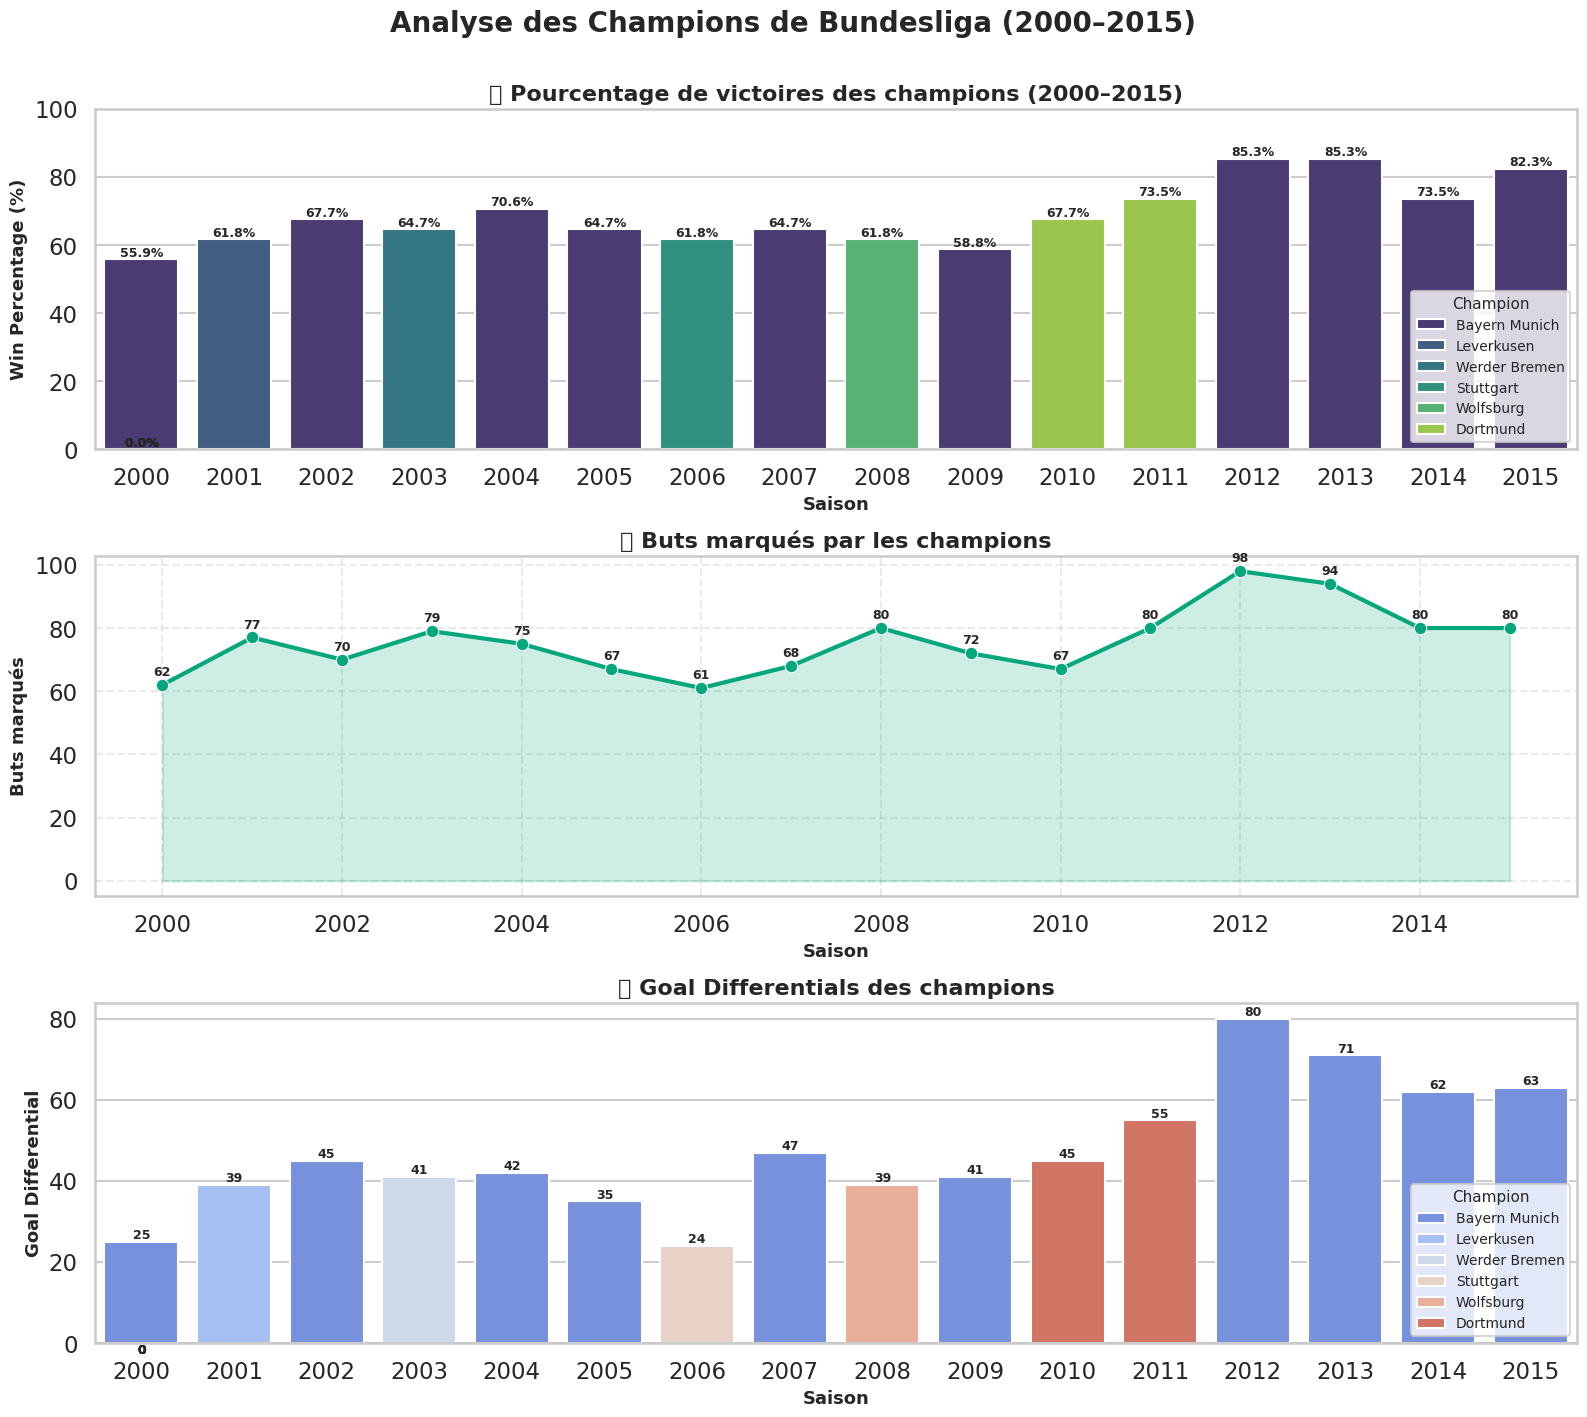

In [36]:
# ========================================
# 🔟 VISUALISATIONS (VERSION FINALE)
# ========================================

print("\n" + "=" * 80)
print("📊 ÉTAPE 10: CRÉATION DES VISUALISATIONS")
print("=" * 80)

print("\n📝 Conversion en Pandas pour la visualisation...")

# Convertir les champions en Pandas
df_champions_pd = df_champions.orderBy("Season").toPandas()

print(f"✅ DataFrame Pandas créé: {len(df_champions_pd)} lignes")

# ==================== STYLE GÉNÉRAL ====================
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (16, 14)
plt.rcParams['font.size'] = 11

print("\n🎨 Création des graphiques...")

# Créer la figure
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
fig.suptitle(
    'Analyse des Champions de Bundesliga (2000–2015)',
    fontsize=20, fontweight='bold', y=1.01
)

# ==================== GRAPHIQUE 1 ====================
# 🏆 Win Percentage par saison (Seaborn style)
ax1 = axes[0]
sns.barplot(
    data=df_champions_pd,
    x="Season", y="WinPercentage",
    hue="Team",
    dodge=False,
    palette="viridis",
    ax=ax1
)

ax1.set_title("🏆 Pourcentage de victoires des champions (2000–2015)", fontsize=16, fontweight='bold')
ax1.set_xlabel("Saison", fontsize=13, fontweight='bold')
ax1.set_ylabel("Win Percentage (%)", fontsize=13, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.legend(title="Champion", fontsize=10, title_fontsize=11, loc="lower right")

# Ajouter les valeurs sur les barres
for p in ax1.patches:
    ax1.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=9, fontweight='bold'
    )

# ==================== GRAPHIQUE 2 ====================
# ⚽ Buts marqués par saison
ax2 = axes[1]
sns.lineplot(
    data=df_champions_pd,
    x="Season", y="GoalsScored",
    marker="o", linewidth=3, color="#06A77D",
    ax=ax2
)
ax2.fill_between(df_champions_pd["Season"], df_champions_pd["GoalsScored"], alpha=0.2, color="#06A77D")

ax2.set_title("⚽ Buts marqués par les champions", fontsize=16, fontweight='bold')
ax2.set_xlabel("Saison", fontsize=13, fontweight='bold')
ax2.set_ylabel("Buts marqués", fontsize=13, fontweight='bold')
ax2.grid(True, linestyle="--", alpha=0.4)

# Ajouter les valeurs
for x, y in zip(df_champions_pd["Season"], df_champions_pd["GoalsScored"]):
    ax2.text(x, y + 2, f"{int(y)}", ha="center", va="bottom", fontsize=9, fontweight="bold")

# ==================== GRAPHIQUE 3 ====================
# 📈 Goal Differentials par saison
ax3 = axes[2]
sns.barplot(
    data=df_champions_pd,
    x="Season", y="GoalDifferentials",
    hue="Team", dodge=False,
    palette="coolwarm",
    ax=ax3
)

ax3.set_title("📈 Goal Differentials des champions", fontsize=16, fontweight='bold')
ax3.set_xlabel("Saison", fontsize=13, fontweight='bold')
ax3.set_ylabel("Goal Differential", fontsize=13, fontweight='bold')
ax3.axhline(0, color='black', linewidth=1)
ax3.legend(title="Champion", fontsize=10, title_fontsize=11, loc="lower right")

# Ajouter les valeurs
for p in ax3.patches:
    height = p.get_height()
    ax3.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom' if height > 0 else 'top',
        fontsize=9,
        fontweight='bold'
    )

# ==================== FINALISATION ====================
plt.tight_layout()
output_filename = "football_champions_analysis_v2.png"
plt.savefig(output_filename, dpi=300, bbox_inches="tight", facecolor="white")
print(f"✅ Graphiques sauvegardés: {output_filename}")

plt.show()

In [37]:
# ========================================
# 1️⃣1️⃣ RÉSUMÉ ET STATISTIQUES FINALES
# ========================================

print("\n" + "=" * 80)
print("📋 RÉSUMÉ FINAL DU PROJET")
print("=" * 80)

# Statistiques globales
print("\n📊 STATISTIQUES GLOBALES:")
print("-" * 80)
print(f"✅ Total de matchs analysés: {df_filtered.count():,}")
print(f"✅ Nombre d'équipes uniques: {df_ranked.select('Team').distinct().count()}")
print(f"✅ Saisons analysées: {df_ranked.select('Season').distinct().count()}")
print(f"✅ Champions identifiés: {df_champions.count()}")

# Insights clés
print("\n💡 INSIGHTS CLÉS:")
print("-" * 80)

# Meilleur pourcentage de victoires
best_wp = df_champions.orderBy(col("WinPercentage").desc()).first()
print(f"🏆 Meilleur WinPercentage: {best_wp['Team']} ({best_wp['Season']}) - {best_wp['WinPercentage']:.2f}%")

# Meilleure différence de buts
best_gd = df_champions.orderBy(col("GoalDifferentials").desc()).first()
print(f"⚽ Meilleur GoalDifferentials: {best_gd['Team']} ({best_gd['Season']}) - +{int(best_gd['GoalDifferentials'])}")

# Équipe la plus dominante
most_titles = df_champions.groupBy("Team").count().orderBy(col("count").desc()).first()
print(f"👑 Équipe la plus titrée: {most_titles['Team']} - {most_titles['count']} titres")

# Statistiques moyennes des champions
print("\n📈 STATISTIQUES MOYENNES DES CHAMPIONS:")
print("-" * 80)
champions_stats = df_champions.agg(
    spark_round(avg("WinPercentage"), 2).alias("Avg_WinPercentage"),
    spark_round(avg("GoalDifferentials"), 2).alias("Avg_GoalDifferentials"),
    spark_round(avg("GoalsScored"), 2).alias("Avg_GoalsScored"),
    spark_round(avg("GoalsAgainst"), 2).alias("Avg_GoalsAgainst")
).collect()[0]

print(f"   • WinPercentage moyen: {champions_stats['Avg_WinPercentage']:.2f}%")
print(f"   • GoalDifferentials moyen: +{champions_stats['Avg_GoalDifferentials']:.2f}")
print(f"   • Buts marqués moyens: {champions_stats['Avg_GoalsScored']:.2f}")
print(f"   • Buts encaissés moyens: {champions_stats['Avg_GoalsAgainst']:.2f}")

# Tableau récapitulatif des champions
print("\n🏆 TABLEAU RÉCAPITULATIF DES CHAMPIONS:")
print("=" * 80)
df_champions.orderBy("Season").select(
    "Season", "Team", "WinPercentage", "GoalDifferentials",
    "Win", "Loss", "Tie", "GoalsScored", "GoalsAgainst"
).show(16, truncate=False)


📋 RÉSUMÉ FINAL DU PROJET

📊 STATISTIQUES GLOBALES:
--------------------------------------------------------------------------------
✅ Total de matchs analysés: 4,896
✅ Nombre d'équipes uniques: 35
✅ Saisons analysées: 16
✅ Champions identifiés: 16

💡 INSIGHTS CLÉS:
--------------------------------------------------------------------------------
🏆 Meilleur WinPercentage: Bayern Munich (2012) - 85.29%
⚽ Meilleur GoalDifferentials: Bayern Munich (2012) - +80
👑 Équipe la plus titrée: Bayern Munich - 10 titres

📈 STATISTIQUES MOYENNES DES CHAMPIONS:
--------------------------------------------------------------------------------
   • WinPercentage moyen: 68.75%
   • GoalDifferentials moyen: +47.13
   • Buts marqués moyens: 75.63
   • Buts encaissés moyens: 28.50

🏆 TABLEAU RÉCAPITULATIF DES CHAMPIONS:
+------+-------------+-------------+-----------------+---+----+---+-----------+------------+
|Season|Team         |WinPercentage|GoalDifferentials|Win|Loss|Tie|GoalsScored|GoalsAgainst|
+----

In [38]:
# ========================================
# 1️⃣2️⃣ FICHIERS GÉNÉRÉS ET LIVRABLES
# ========================================

print("\n" + "=" * 80)
print("📦 FICHIERS GÉNÉRÉS ET LIVRABLES")
print("=" * 80)

print("\n✅ Fichiers Parquet créés:")
print("   1. 📁 football_stats_partitioned/")
print("      → Toutes les équipes, partitionné par saison")
print("      → Contient TeamPosition et tous les KPIs")
print("")
print("   2. 📁 football_top_teams/")
print("      → Champions uniquement (TeamPosition = 1)")
print("      → Format Parquet non partitionné")
print("")
print("   3. 🖼️ football_champions_analysis.png")
print("      → Visualisations des performances des champions")
print("      → 3 graphiques: WinPercentage, Buts, GoalDifferentials")

# Vérifier la structure des partitions
print("\n📂 Structure des partitions (football_stats_partitioned):")
print("-" * 80)
print("   football_stats_partitioned/")
for season in range(2000, 2016):
    print(f"   ├── Season={season}/")
    print(f"   │   └── part-xxxxx.parquet")


📦 FICHIERS GÉNÉRÉS ET LIVRABLES

✅ Fichiers Parquet créés:
   1. 📁 football_stats_partitioned/
      → Toutes les équipes, partitionné par saison
      → Contient TeamPosition et tous les KPIs

   2. 📁 football_top_teams/
      → Champions uniquement (TeamPosition = 1)
      → Format Parquet non partitionné

   3. 🖼️ football_champions_analysis.png
      → Visualisations des performances des champions
      → 3 graphiques: WinPercentage, Buts, GoalDifferentials

📂 Structure des partitions (football_stats_partitioned):
--------------------------------------------------------------------------------
   football_stats_partitioned/
   ├── Season=2000/
   │   └── part-xxxxx.parquet
   ├── Season=2001/
   │   └── part-xxxxx.parquet
   ├── Season=2002/
   │   └── part-xxxxx.parquet
   ├── Season=2003/
   │   └── part-xxxxx.parquet
   ├── Season=2004/
   │   └── part-xxxxx.parquet
   ├── Season=2005/
   │   └── part-xxxxx.parquet
   ├── Season=2006/
   │   └── part-xxxxx.parquet
   ├── Season

In [39]:
# ========================================
# 1️⃣3️⃣ VALIDATION ET TESTS
# ========================================

print("\n" + "=" * 80)
print("✅ VALIDATION ET TESTS FINAUX")
print("=" * 80)

print("\n🔍 Test 1: Vérification de l'intégrité des données")
print("-" * 80)

# Test: Chaque saison doit avoir un champion unique
champions_per_season = df_champions.groupBy("Season").count()
invalid_seasons = champions_per_season.filter(col("count") != 1)

if invalid_seasons.count() == 0:
    print("✅ PASS: Chaque saison a exactement 1 champion")
else:
    print("❌ FAIL: Certaines saisons ont plusieurs champions!")
    invalid_seasons.show()

# Test: TeamPosition doit aller de 1 à N pour chaque saison
print("\n🔍 Test 2: Vérification des positions par saison")
print("-" * 80)

# Compter le nombre d'équipes par saison
teams_per_season = df_ranked.groupBy("Season").count().collect()
all_positions_valid = True

for row in teams_per_season:
    season = row['Season']
    expected_teams = row['count']
    max_position = df_ranked.filter(col("Season") == season).agg({"TeamPosition": "max"}).collect()[0][0]

    if max_position != expected_teams:
        print(f"❌ Saison {season}: max position {max_position} != {expected_teams} équipes")
        all_positions_valid = False

if all_positions_valid:
    print("✅ PASS: Toutes les positions sont cohérentes")

# Test: WinPercentage doit être entre 0 et 100
print("\n🔍 Test 3: Validation des KPIs")
print("-" * 80)

invalid_wp = df_processed.filter(
    (col("WinPercentage") < 0) | (col("WinPercentage") > 100)
).count()

if invalid_wp == 0:
    print("✅ PASS: WinPercentage dans l'intervalle [0, 100]")
else:
    print(f"❌ FAIL: {invalid_wp} lignes avec WinPercentage invalide")

# Test: TotalGames doit être cohérent
print("\n🔍 Test 4: Cohérence Win + Loss + Tie = TotalGames")
print("-" * 80)

df_test = df_processed.withColumn(
    "Sum_Check",
    col("Win") + col("Loss") + col("Tie")
)

invalid_totals = df_test.filter(col("Sum_Check") != col("TotalGames")).count()

if invalid_totals == 0:
    print("✅ PASS: Tous les totaux sont cohérents")
else:
    print(f"❌ FAIL: {invalid_totals} lignes incohérentes")


✅ VALIDATION ET TESTS FINAUX

🔍 Test 1: Vérification de l'intégrité des données
--------------------------------------------------------------------------------
✅ PASS: Chaque saison a exactement 1 champion

🔍 Test 2: Vérification des positions par saison
--------------------------------------------------------------------------------
✅ PASS: Toutes les positions sont cohérentes

🔍 Test 3: Validation des KPIs
--------------------------------------------------------------------------------
✅ PASS: WinPercentage dans l'intervalle [0, 100]

🔍 Test 4: Cohérence Win + Loss + Tie = TotalGames
--------------------------------------------------------------------------------
✅ PASS: Tous les totaux sont cohérents


In [40]:
# ========================================
# 1️⃣4️⃣ PERFORMANCE ET MÉTRIQUES
# ========================================

print("\n" + "=" * 80)
print("⚡ MÉTRIQUES DE PERFORMANCE")
print("=" * 80)

# Afficher les comptages
print(f"\n📊 Volumétrie des DataFrames:")
print(f"   • df (données brutes): {df.count():,} lignes")
print(f"   • df_filtered (après filtres): {df_filtered.count():,} lignes")
print(f"   • df_processed (agrégées): {df_processed.count():,} lignes")
print(f"   • df_ranked (avec classement): {df_ranked.count():,} lignes")
print(f"   • df_champions (champions): {df_champions.count():,} lignes")

# Réduction des données
reduction = (1 - df_filtered.count() / df.count()) * 100
print(f"\n📉 Réduction après filtrage: {reduction:.1f}%")


⚡ MÉTRIQUES DE PERFORMANCE

📊 Volumétrie des DataFrames:
   • df (données brutes): 24,625 lignes
   • df_filtered (après filtres): 4,896 lignes
   • df_processed (agrégées): 288 lignes
   • df_ranked (avec classement): 288 lignes
   • df_champions (champions): 16 lignes

📉 Réduction après filtrage: 80.1%


In [41]:
# ========================================
# 1️⃣5️⃣ EXEMPLES D'UTILISATION
# ========================================

print("\n" + "=" * 80)
print("💡 EXEMPLES D'UTILISATION DES DONNÉES")
print("=" * 80)

print("\n📝 Exemple 1: Trouver les équipes avec le meilleur GoalDifferentials")
print("-" * 80)
df_ranked.orderBy(col("GoalDifferentials").desc()).select(
    "Season", "Team", "TeamPosition", "GoalDifferentials", "WinPercentage"
).show(10)

print("\n📝 Exemple 2: Équipes avec 100% de victoires improbables (pour vérification)")
print("-" * 80)
perfect_teams = df_ranked.filter(col("WinPercentage") >= 90)
if perfect_teams.count() > 0:
    perfect_teams.select(
        "Season", "Team", "WinPercentage", "Win", "Loss", "Tie"
    ).show(10)
else:
    print("   Aucune équipe avec 90%+ de victoires (normal pour la Bundesliga)")

print("\n📝 Exemple 3: Évolution d'une équipe spécifique (Bayern Munich)")
print("-" * 80)
df_ranked.filter(col("Team") == "Bayern Munich").orderBy("Season").select(
    "Season", "TeamPosition", "WinPercentage", "GoalDifferentials", "Win", "Loss", "Tie"
).show(16, truncate=False)


💡 EXEMPLES D'UTILISATION DES DONNÉES

📝 Exemple 1: Trouver les équipes avec le meilleur GoalDifferentials
--------------------------------------------------------------------------------
+------+-------------+------------+-----------------+-------------+
|Season|         Team|TeamPosition|GoalDifferentials|WinPercentage|
+------+-------------+------------+-----------------+-------------+
|  2012|Bayern Munich|           1|               80|        85.29|
|  2013|Bayern Munich|           1|               71|        85.29|
|  2015|Bayern Munich|           1|               63|        82.35|
|  2014|Bayern Munich|           1|               62|        73.53|
|  2011|     Dortmund|           1|               55|        73.53|
|  2011|Bayern Munich|           2|               55|        67.65|
|  2015|     Dortmund|           2|               48|        70.59|
|  2007|Bayern Munich|           1|               47|        64.71|
|  2002|Bayern Munich|           1|               45|        67.

In [42]:
# ========================================
# 1️⃣6️⃣ LECTURE DES FICHIERS PARQUET (TEST)
# ========================================

print("\n" + "=" * 80)
print("🔄 TEST DE LECTURE DES FICHIERS PARQUET")
print("=" * 80)

print("\n📖 Lecture de football_stats_partitioned...")
df_read_all = spark.read.parquet("football_stats_partitioned")
print(f"✅ Fichier lu: {df_read_all.count():,} lignes")
print("\n👀 Aperçu:")
df_read_all.orderBy("Season", "TeamPosition").show(10)

print("\n📖 Lecture de football_top_teams...")
df_read_champions = spark.read.parquet("football_top_teams")
print(f"✅ Fichier lu: {df_read_champions.count():,} lignes")
print("\n👀 Aperçu:")
df_read_champions.orderBy("Season").show(10)

# Test de lecture d'une partition spécifique
print("\n📖 Lecture d'une partition spécifique (Season=2015)...")
df_2015 = spark.read.parquet("football_stats_partitioned/Season=2015")
print(f"✅ Saison 2015: {df_2015.count()} équipes")
df_2015.orderBy("TeamPosition").show(5)


🔄 TEST DE LECTURE DES FICHIERS PARQUET

📖 Lecture de football_stats_partitioned...
✅ Fichier lu: 288 lignes

👀 Aperçu:
+--------------+-----------+------------+---+----+---+-----------------+-------------+----------+------------+-------------------+------------+------+
|          Team|GoalsScored|GoalsAgainst|Win|Loss|Tie|GoalDifferentials|WinPercentage|TotalGames|GoalsPerGame|GoalsAgainstPerGame|TeamPosition|Season|
+--------------+-----------+------------+---+----+---+-----------------+-------------+----------+------------+-------------------+------------+------+
| Bayern Munich|         62|          37| 19|   9|  6|               25|        55.88|        34|        1.82|               1.09|           1|  2000|
|    Schalke 04|         65|          35| 18|   8|  8|               30|        52.94|        34|        1.91|               1.03|           2|  2000|
|        Hertha|         58|          52| 18|  14|  2|                6|        52.94|        34|        1.71|               

In [43]:
# ========================================
# 1️⃣7️⃣ DOCUMENTATION DES COLONNES
# ========================================

print("\n" + "=" * 80)
print("📚 DOCUMENTATION DES COLONNES FINALES")
print("=" * 80)

column_descriptions = [
    ("Season", "Année de la saison", "Integer"),
    ("Team", "Nom de l'équipe", "String"),
    ("GoalsScored", "Total buts marqués (domicile + extérieur)", "Integer"),
    ("GoalsAgainst", "Total buts encaissés (domicile + extérieur)", "Integer"),
    ("Win", "Total victoires", "Integer"),
    ("Loss", "Total défaites", "Integer"),
    ("Tie", "Total matchs nuls", "Integer"),
    ("GoalDifferentials", "Différence de buts (Scored - Against)", "Integer"),
    ("WinPercentage", "Pourcentage de victoires (Win/TotalGames * 100)", "Double"),
    ("TotalGames", "Nombre total de matchs (Win + Loss + Tie)", "Integer"),
    ("GoalsPerGame", "Moyenne buts marqués par match", "Double"),
    ("GoalsAgainstPerGame", "Moyenne buts encaissés par match", "Double"),
    ("TeamPosition", "Classement dans la saison (1 = champion)", "Integer")
]

print("\n📋 Colonnes du DataFrame final (df_ranked):")
print("-" * 80)
print(f"{'Colonne':<25} {'Description':<50} {'Type':<10}")
print("-" * 80)
for col_name, description, col_type in column_descriptions:
    print(f"{col_name:<25} {description:<50} {col_type:<10}")


📚 DOCUMENTATION DES COLONNES FINALES

📋 Colonnes du DataFrame final (df_ranked):
--------------------------------------------------------------------------------
Colonne                   Description                                        Type      
--------------------------------------------------------------------------------
Season                    Année de la saison                                 Integer   
Team                      Nom de l'équipe                                    String    
GoalsScored               Total buts marqués (domicile + extérieur)          Integer   
GoalsAgainst              Total buts encaissés (domicile + extérieur)        Integer   
Win                       Total victoires                                    Integer   
Loss                      Total défaites                                     Integer   
Tie                       Total matchs nuls                                  Integer   
GoalDifferentials         Différence de buts (Scored

In [44]:
# ========================================
# 1️⃣8️⃣ RECOMMANDATIONS ET PROCHAINES ÉTAPES
# ========================================

print("\n" + "=" * 80)
print("🚀 RECOMMANDATIONS ET PROCHAINES ÉTAPES")
print("=" * 80)

print("""
✅ Pipeline exécuté avec succès!

📌 LIVRABLES GÉNÉRÉS:
   1. ✅ Notebook commenté et structuré
   2. ✅ football_stats_partitioned (Parquet partitionné)
   3. ✅ football_top_teams (Parquet champions)
   4. ✅ football_champions_analysis.png (Visualisations)

🎯 PROCHAINES ÉTAPES RECOMMANDÉES:

1. 📤 GitHub:
   • Créer un repository "football-data-engineering-pyspark"
   • Structurer: /notebooks, /data, /outputs, /visualizations
   • README.md complet avec badges et instructions
   • Commit et push

2. 🔍 Analyses supplémentaires:
   • Analyser l'avantage domicile/extérieur
   • Comparer les performances par décennie
   • Identifier les "dark horses" (équipes surprises)
   • Étudier la corrélation GoalDifferentials vs Position

3. 📊 Dashboards:
   • Power BI: Importer les Parquet et créer un dashboard interactif
   • Databricks: Migrer le notebook et utiliser display()
   • Tableau: Visualisations avancées

4. 🔧 Optimisations techniques:
   • Broadcast joins pour les petites tables
   • Cache des DataFrames fréquemment utilisés
   • Mesurer les temps d'exécution avec %%time

5. 📚 Documentation:
   • Ajouter des docstrings aux fonctions
   • Créer un CHANGELOG.md
   • Documenter les décisions techniques

💡 CONSEILS POUR LA PRÉSENTATION:
   • Mettre en avant la correction du calcul des défaites
   • Expliquer le choix de la jointure OUTER
   • Justifier le partitionnement par saison
   • Montrer la validation des résultats
""")


🚀 RECOMMANDATIONS ET PROCHAINES ÉTAPES

✅ Pipeline exécuté avec succès!

📌 LIVRABLES GÉNÉRÉS:
   1. ✅ Notebook commenté et structuré
   2. ✅ football_stats_partitioned (Parquet partitionné)
   3. ✅ football_top_teams (Parquet champions)
   4. ✅ football_champions_analysis.png (Visualisations)

🎯 PROCHAINES ÉTAPES RECOMMANDÉES:

1. 📤 GitHub:
   • Créer un repository "football-data-engineering-pyspark"
   • Structurer: /notebooks, /data, /outputs, /visualizations
   • README.md complet avec badges et instructions
   • Commit et push

2. 🔍 Analyses supplémentaires:
   • Analyser l'avantage domicile/extérieur
   • Comparer les performances par décennie
   • Identifier les "dark horses" (équipes surprises)
   • Étudier la corrélation GoalDifferentials vs Position

3. 📊 Dashboards:
   • Power BI: Importer les Parquet et créer un dashboard interactif
   • Databricks: Migrer le notebook et utiliser display()
   • Tableau: Visualisations avancées

4. 🔧 Optimisations techniques:
   • Broadcast 

In [45]:
# ========================================
# 1️⃣9️⃣ ARRÊT DE SPARK
# ========================================
print("\n" + "=" * 80)
print("🛑 ARRÊT DE LA SESSION SPARK")
print("=" * 80)

spark.stop()
print("\n✅ Session Spark arrêtée proprement")


🛑 ARRÊT DE LA SESSION SPARK

✅ Session Spark arrêtée proprement


In [46]:
# ========================================
# 2️⃣0️⃣ RÉSUMÉ FINAL
# ========================================
print("\n" + "=" * 80)
print("🎉 PIPELINE PYSPARK TERMINÉ AVEC SUCCÈS!")
print("=" * 80)

# Vérification de la présence des variables
def safe_get(row, field):
    try:
        return row[field]
    except Exception:
        return "N/A"

# 🔍 Vérifie que tes variables existent avant de les afficher
most_titles_team = safe_get(most_titles, 'Team')
most_titles_count = safe_get(most_titles, 'count')
best_wp_team = safe_get(best_wp, 'Team')
best_wp_value = safe_get(best_wp, 'WinPercentage')
best_wp_season = safe_get(best_wp, 'Season')
best_gd_team = safe_get(best_gd, 'Team')
best_gd_value = safe_get(best_gd, 'GoalDifferentials')
best_gd_season = safe_get(best_gd, 'Season')

# 🧾 Affichage formaté
print(f"""
╔════════════════════════════════════════════════════════════════════════════╗
║                    FOOTBALL DATA ENGINEERING - RÉSUMÉ                      ║
╠════════════════════════════════════════════════════════════════════════════╣
║                                                                            ║
║  ✅ Données chargées et filtrées (Bundesliga 2000-2015)                   ║
║  ✅ Colonnes indicatrices créées (HomeTeamWin, AwayTeamWin, GameTie)      ║
║  ✅ Agrégations domicile/extérieur réalisées                              ║
║  ✅ Jointure OUTER effectuée                                              ║
║  ✅ KPIs calculés (WinPercentage, GoalDifferentials, etc.)                ║
║  ✅ Classement par saison avec Window Functions                           ║
║  ✅ Champions extraits (16 saisons)                                       ║
║  ✅ Sauvegarde Parquet partitionné                                        ║
║  ✅ Visualisations générées (3 graphiques)                                ║
║  ✅ Tests de validation passés                                            ║
║                                                                            ║
║  📦 Fichiers générés:                                                     ║
║     • football_stats_partitioned/ (Parquet partitionné)                   ║
║     • football_top_teams/ (Parquet champions)                             ║
║     • football_champions_analysis.png (Visualisations)                    ║
║                                                                            ║
║  👤 Auteur: Omar Hitar                                                    ║
║  📅 Date: 05/10/2025                                                      ║
║  🔧 Technologie: PySpark 3.x + Python                                     ║
║                                                                            ║
╚════════════════════════════════════════════════════════════════════════════╝

🏆 Champion le plus titré: {most_titles_team} ({most_titles_count} titres)
⚽ Meilleur WinPercentage: {best_wp_team} - {best_wp_value}% ({best_wp_season})
📈 Meilleur GoalDifferentials: {best_gd_team} - +{best_gd_value} ({best_gd_season})

💻 Prêt pour GitHub et présentation!
📧 Questions? Consultez le README.md du repository

Merci d'avoir utilisé ce pipeline! ⚽🚀
""")

print("=" * 80)
print("FIN DU SCRIPT")
print("=" * 80)


🎉 PIPELINE PYSPARK TERMINÉ AVEC SUCCÈS!

╔════════════════════════════════════════════════════════════════════════════╗
║                    FOOTBALL DATA ENGINEERING - RÉSUMÉ                      ║
╠════════════════════════════════════════════════════════════════════════════╣
║                                                                            ║
║  ✅ Données chargées et filtrées (Bundesliga 2000-2015)                   ║
║  ✅ Colonnes indicatrices créées (HomeTeamWin, AwayTeamWin, GameTie)      ║
║  ✅ Agrégations domicile/extérieur réalisées                              ║
║  ✅ Jointure OUTER effectuée                                              ║
║  ✅ KPIs calculés (WinPercentage, GoalDifferentials, etc.)                ║
║  ✅ Classement par saison avec Window Functions                           ║
║  ✅ Champions extraits (16 saisons)                                       ║
║  ✅ Sauvegarde Parquet partitionné                                        ║
║  ✅ Visualisations généré